# LD Score Regression: Update FTND with GWAS of Cotinine
**Author**: Jesse Marks <br>
**GitHub Issue:** [#103](https://github.com/RTIInternational/bioinformatics/issues/103)

LD score regression (LDSC) analyses are needed for EUR-specific meta-analysis results for FTND. Dana Hancock is wanting to update the latest LDSC for FTND by including the 2016 Nature Scientific Reports paper: [Genome-Wide Meta-Analysis of Cotinine Levels in Cigarette Smokers Identifies Locus at 4q13.2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4735517/) (biomarker for exposure to tobacco smoke). [Full summary statistics results can be found here ](https://data.bris.ac.uk/data/dataset/182rhz19hg3lz1172a7yfcap9v).

We are going to utilize the [LD score regression pipeline](https://github.com/RTIInternational/ld-regression-pipeline) that Alex Waldrop developed to perform LD score regression. We will be using the LDSC pipeline on Docker to complete these analyses. Alex was the last to run LDSC for FTND and you can find the plot and table [at this link](https://github.com/RTIInternational/bioinformatics/issues/103#issuecomment-514772578).

<br><br>

### Workflow guideline
 1. Create Excel phenotype file locally then upload to EC2 instance
 2. Clone https://github.com/RTIInternational/ld-regression-pipeline
 3. Then edit full_ld_regression_wf_template.json to include the reference data of choice
 4. Use dockerized tool to finish filling out the json file that will be input for workflow
 5. Run the WDL workflow for LDSC

### workflow ID number:
`bbaffaf1-a585-4f44-9c5e-2f9f135abeda`

## Create WorkFlow inputs
Here is an example entry in the Excel Phenotype File:

**trait	plot_label	sumstats_path	pmid	category	sample_size	id_col	chr_col	pos_col	effect_allele_col	ref_allele_col	effect_col	pvalue_col	sample_size_col	effect_type	w_ld_chr**
```
COPDGWAS Hobbs et al.	COPD	s3://rti-nd/LDSC/COPDGWAS_HobbsEtAl/modGcNoOtherMinMissSorted.withchrpos.txt.gz	28166215	Respiratory	51772	3	1	2	4	5	10	12		beta	s3://clustername--files/eur_w_ld_chr.tar.bz2
```

### data wrangling
Create input file for GWAS of Cotinine. We need to add chromosome and position information. We also had to filter out 18 SNPs that had missing data because they were causing the workflow to crash. For example:

grep rs74380574 cotinine_ldsc_cromwell_ready_chr3.txt
```
3       186494703       rs74380574      A       G       nAn     nAn     nAn     nAnenAn 4330
```

In [ ]:
### EC2 ###
mkdir -p /shared/jmarks/nicotine/ldsc/ftnd_cotinine/001/processing
cd /shared/jmarks/nicotine/ldsc/ftnd_cotinine/001/processing

head 2015.10.22\ Cotinine\ GWAS\ Data\ Sheet.txt

```
SNP     A1      A2      freq    b       se      p       N
rs2326918       A       G       0.8659  -0.0184 0.0301  0.5412  4548
rs7929618       C       G       0.1148  -0.0048 0.0337  0.8863  4548
rs66941928      T       C       0.7652  0.0121  0.0343  0.7233  3433
```

In [ ]:
### python3 ###

infile = "2015.10.22 Cotinine GWAS Data Sheet.txt"
for chrom in range(1,23):
    plink_file = "/shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{}.bim".format(chrom)
    outfile = "cotinine_ldsc_cromwell_ready_chr{}.txt".format(chrom)

    with open(infile) as inF, open(plink_file) as pF, open(outfile, "w") as outF:
        plink_set = set()
        line = pF.readline()

        while line:
            sl = line.split()
            full_id = frozenset([sl[1], sl[4], sl[5]]) # rsid, a1, a2 in a set
            plink_set.add(full_id)
            line = pF.readline()

        head = inF.readline().split()
        head.insert(0, "chr")
        head = "\t".join(head)
        outF.write(head + "\n")

        line = inF.readline()
        while line:
            sl = line.split()
            full_id = frozenset([sl[0], sl[1], sl[2]]) # rsid, a1, a2 in a set

            if full_id in plink_set:
                sl.insert(0, str(chrom))
                new_line = "\t".join(sl) + "\n"
                outF.write(new_line)

            line = inF.readline()

In [ ]:
### EC2 ###
procD=/shared/jmarks/nicotine/ldsc/ftnd_cotinine/001
cd $procD/processing
for chr in {1..22}; do 
    if [ $chr == 1 ]; then
        cat cotinine_ldsc_cromwell_ready_chr1.txt > cotinine_ldsc_cromwell_ready_chr_all.txt
    else
        tail -n +2 cotinine_ldsc_cromwell_ready_chr$chr.txt >>\
            cotinine_ldsc_cromwell_ready_chr_all.txt
    fi
done &

## remove lines with nAn
grep  nAn cotinine_ldsc_cromwell_ready_chr_all.txt | awk '{print $3}' > remove_list_nan.txt
awk 'NR==FNR{map[$1]=$1; next} {if (!($3 in map)) {print $0}}  '\
    remove_list_nan.txt cotinine_ldsc_cromwell_ready_chr_all.txt > tmp && mv tmp cotinine_ldsc_cromwell_ready_chr_all.txt


## upload to s3

gzip cotinine_ldsc_cromwell_ready_chr_all.txt
aws s3 cp cotinine_ldsc_cromwell_ready_chr_all.txt.gz \
    s3://rti-nd/LDSC/cotinine/cotinine_ldsc_cromwell_ready_chr_all.txt.gz

In [ ]:
### local ###

cd /home/jmarks/Projects/nicotine/ldsc/ftnd_vs_cotinine/001
mkdir -p final processing/{input,output}
cd processing/input

## construct phenotype file input Excel sheet
## construct full_ld_regression_wf_template.json


In [ ]:
### EC2 ###
procD=/shared/jmarks/nicotine/ldsc/ftnd_cotinine/001

# enter compute node and use screen tool
qrsh -l h=ip-172-31-29-161
screen 

# clone github repo
cd $procD
git clone https://github.com/RTIInternational/ld-regression-pipeline
    
# edit file-input json
cd ld-regression-pipeline
mkdir workflow_inputs
cp json_input/full_ld_regression_wf_template.json workflow_inputs
cd workflow_inputs

## vim edit file (see README.md at https://github.com/RTIInternational/ld-regression-pipeline)

In [ ]:
### local ###

## edit phenotype file and upload to EC2 instance
cd /home/jmarks/Projects/nicotine/ldsc/ftnd_vs_cotinine/001
scp -i ~/.ssh/gwas_rsa hiv*xlsx ec2-user@3.221.213.211:/shared/jmarks/nicotine/ldsc/ftnd_cotinine/001/ld-regression-pipeline/workflow_inputs

In [ ]:
### EC2 ###

# create final workflow input (a json file)
docker run -v $procD/ld-regression-pipeline/workflow_inputs:/data/ \
    rticode/generate_ld_regression_input_json:1ddbd682cb1e44dab6d11ee571add34bd1d06e21 \
    --json-input /data/full_ld_regression_wf_template.json \
    --pheno-file /data/ftnd_ldsc_phenotypes_local.xlsx >\
        $procD/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json

## Run Analysis Workflow

In [ ]:
## zip appropriate files 
# Change to directory immediately above ld-regression-pipeline
cd $procD/ld-regression-pipeline
cd ..
# Make zipped copy of repo somewhere
zip --exclude=*var/* --exclude=*.git/* -r \
    $procD/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip \
    ld-regression-pipeline

## download cromwell and the config file, if necessary
cd /shared/jmarks/bin/cromwell
#aws s3 cp s3://rti-cromwell-output/cromwell-config/cromwell_default_genomics_queue.conf .
#wget https://github.com/broadinstitute/cromwell/releases/download/44/cromwell-44.jar

## run ldsc workflow on AWS EC2 instance
java -Dconfig.file=/shared/jmarks/bin/cromwell/cromwell_default_genomics_queue.conf \
    -jar cromwell-44.jar \
    run $procD/ld-regression-pipeline/workflow/full_ld_regression_wf.wdl \
    -i $procD/ld-regression-pipeline/workflow_inputs/final_wf_inputs.json \
    -p $procD/ld-regression-pipeline/workflow_inputs/ld-regression-pipeline.zip

Record workflow ID at top.

### Copy Workflow Results to Local

In [ ]:
# copy input files from EC2
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/ldsc/001/input
scp -i ~/.ssh/gwas_rsa  ec2-user@3.221.213.211:/shared/jmarks/projects/nicotine/ldsc/001/ld-regression-pipeline/workflow_inputs/* .

# copy results log files from LDSC
cd ../output/    
aws s3 cp s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/8123c2fa-61ef-4095-9e41-4ccd014c2ebc/call-ld_regression/shard-0/LDSC.single_ld_regression_wf/6d08dfa9-bfbb-4125-8cc8-97948012739c/call-ld_regression/ftnd_by_copd.ldsc_regression.log .
aws s3 cp s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/8123c2fa-61ef-4095-9e41-4ccd014c2ebc/call-ld_regression/shard-1/LDSC.single_ld_regression_wf/46b8b583-9065-440a-ae41-f51ca89ef644/call-ld_regression/ftnd_by_cudipsych.ldsc_regression.log .
    
# copy plot table
aws s3 cp s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/8123c2fa-61ef-4095-9e41-4ccd014c2ebc/call-plot_ld/PLOT.plot_ld_regression_wf/2b30b9c4-9155-4753-acdc-51b4fec8eacb/call-make_plot_table/ftnd_test.ld_regression_results.tsv .

# copy plot
aws s3 cp s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/8123c2fa-61ef-4095-9e41-4ccd014c2ebc/call-plot_ld/PLOT.plot_ld_regression_wf/2b30b9c4-9155-4753-acdc-51b4fec8eacb/call-plot_ld_regression_results/ftnd_test.ld_regression_results.pdf .


## LD Hub
How to prepare/format data for LDHub.

```
Important notes for your uploaded file:

1. To save the uploading time, LD Hub only accepts zipped files as input (e.g. mydata.zip).

2. Please check that there is ONLY ONE plain TXT file (e.g. mydata.txt) in your zipped file.

3. Please make sure you do NOT zip any folder together with the plain txt file (e.g. /myfolder/mydata.txt), otherwise you will get an error: [Errno 2] No such file or directory

4. Please do NOT zip multiple files (e.g. zip mydata.zip file1.txt file2.txt ..) or zip a file with in a folder (e.g. zip mydata.zip /path/to/my/file/mydata.txt).

5. Please keep the file name of your plain txt file short (less than 50 characters), otherwise you may get an error: [Errno 2] No such file or directory

6. Please zip your plain txt file using following command (ONE file at a time):

For Windows system: 1) Locate the file that you want to compress. 2) Right-click the file, point to Send to, and then click Compressed (zipped) folder.

For Linux and Mac OS system: zip mydata.zip mydata.txt

Reminder: for Mac OS system, please do NOT zip you file by right click mouse and click "Compress" to zip your file, this will automatically create a folder called "__MACOS". You will get an error: [Errno 2] No such file or directory.

Upload the trait of interest
To save your upload time, we highly recommend you to use the SNP list we used in LD Hub to reduce the number of SNPs in your uploaded file. Click here to download our SNP list (w_hm3.noMHC.snplist.zip).

Please upload the zipped file you just created. Click here to download an input example.
```

**Note:** for this run, we did not have any LDHub studies to test. They had already been done. We simply added out LDSC results from our pipeline to the previous table of results at:
`s3://rti-nd/LDSC/alex_ldsc_5-14-19/final_figure_6-6-19/ftnd_ld_regression_results_6-6-19.xlsx`

In [ ]:
## Download outputs for each ref chr from rftm_sumstats step
#cd /shared/jmarks/hiv/ldsc/ldhub
#aws s3 sync s3://rti-cromwell-output/cromwell-execution/full_ld_regression_wf/ed5747ed-ccbe-4bc9-bb44-1f2d750a27eb/call-munge_ref/MUNGE_REF_WF.munge_sumstats_wf/e6c9491a-ca22-4ca0-8ad6-79d2b13a6dbe/call-munge_chr_wf/ .
#    
#mv  */MUNGE_CHR.munge_sumstats_chr_wf/*/call-rfmt_sumstats/hiv_acquisition_1df_meta_analysis_uhs1-4_ea+vidus_ea+wihs1_ea.chr*.exclude_singletons.1df.standardized.phase3ID.munge_ready.txt .
#
## Concat into single file
#cat hiv_acquisition_1df_meta_analysis_uhs1-4_ea+vidus_ea+wihs1_ea.chr1.exclude_singletons.1df.standardized.phase3ID.munge_ready.txt >\
#    hiv016_ld_hub_with_pvalues.txt
#for chr in {2..22}
#do
#    tail -n +2  hiv_acquisition_1df_meta_analysis_uhs1-4_ea+vidus_ea+wihs1_ea.chr$chr.exclude_singletons.1df.standardized.phase3ID.munge_ready.txt >>\
#        hiv016_ld_hub_with_pvalues.txt
#done
#
#
## Remove unnecessary columns (need snpID, A1, A2, Beta, Pvalue)
#cat hiv016_ld_hub_with_pvalues.txt | cut -f 1,4,5,6,7 > tmp && mv tmp hiv016_ld_hub_with_pvalues.txt
#
## Add sample size column (sample = 46213.00)
#cat hiv016_ld_hub_with_pvalues.txt | awk -v OFS="\t" -F"\t" '{print $1,$2,$3,$4,"4664.000",$5}' > hiv016_ld_hub.txt
#
## Use vi to change column names to be:
#snpid A1 A2 BETA N P-value

# Update FTND_all plot
We are updating the plot that was posted in GitHub [in this commment](https://github.com/RTIInternational/bioinformatics/issues/103#issuecomment-514772578). We are simply adding the results of this run of LDSC performed between our FTND meta-analysis results and the GWAS of Cotinine (2016). We just need to add our results to the bottom of the input file found at:<br>
`s3://rti-nd/LDSC/alex_ldsc_5-14-19/final_figure_6-6-19/figure_input_files/ftnd_revised_plot_table_6-6-19.csv`

cat ftnd_rg_plot_order.csv
```
Cigarette smoking
Drug and alcohol use
Cancer
Cardiometabolic
Respiratory
Neurological
Cognitive/Education
Personality
Psychiatric
Brain volume
```

In [ ]:
### EC2 ###
procD=/shared/jmarks/nicotine/ldsc/ftnd_all/20191023/plot
cd $procD

# enter interactive mode
docker run -it -v"$procD:/data" \
    rticode/plot_ld_regression_results:7bbd11a1d0c664bcb8bede8c398772b13abe15b3 /bin/bash

In [ ]:
# interactive bash
prefix=20191023_ftnd_ld_regression_results

Rscript /opt/plot_ld_regression/plot_ld_regression_results.R \
    --input_file $prefix.csv \
    --output_file $prefix.pdf \
    --group_order_file ftnd_rg_plot_order.csv \
    --comma_delimited

In [ ]:
### local ###

# copy results to local
scp -i ~/.ssh/gwas_rsa  ec2-user@3.221.213.211:/shared/jmarks/projects/nicotine/ldsc/001/final/*pdf .

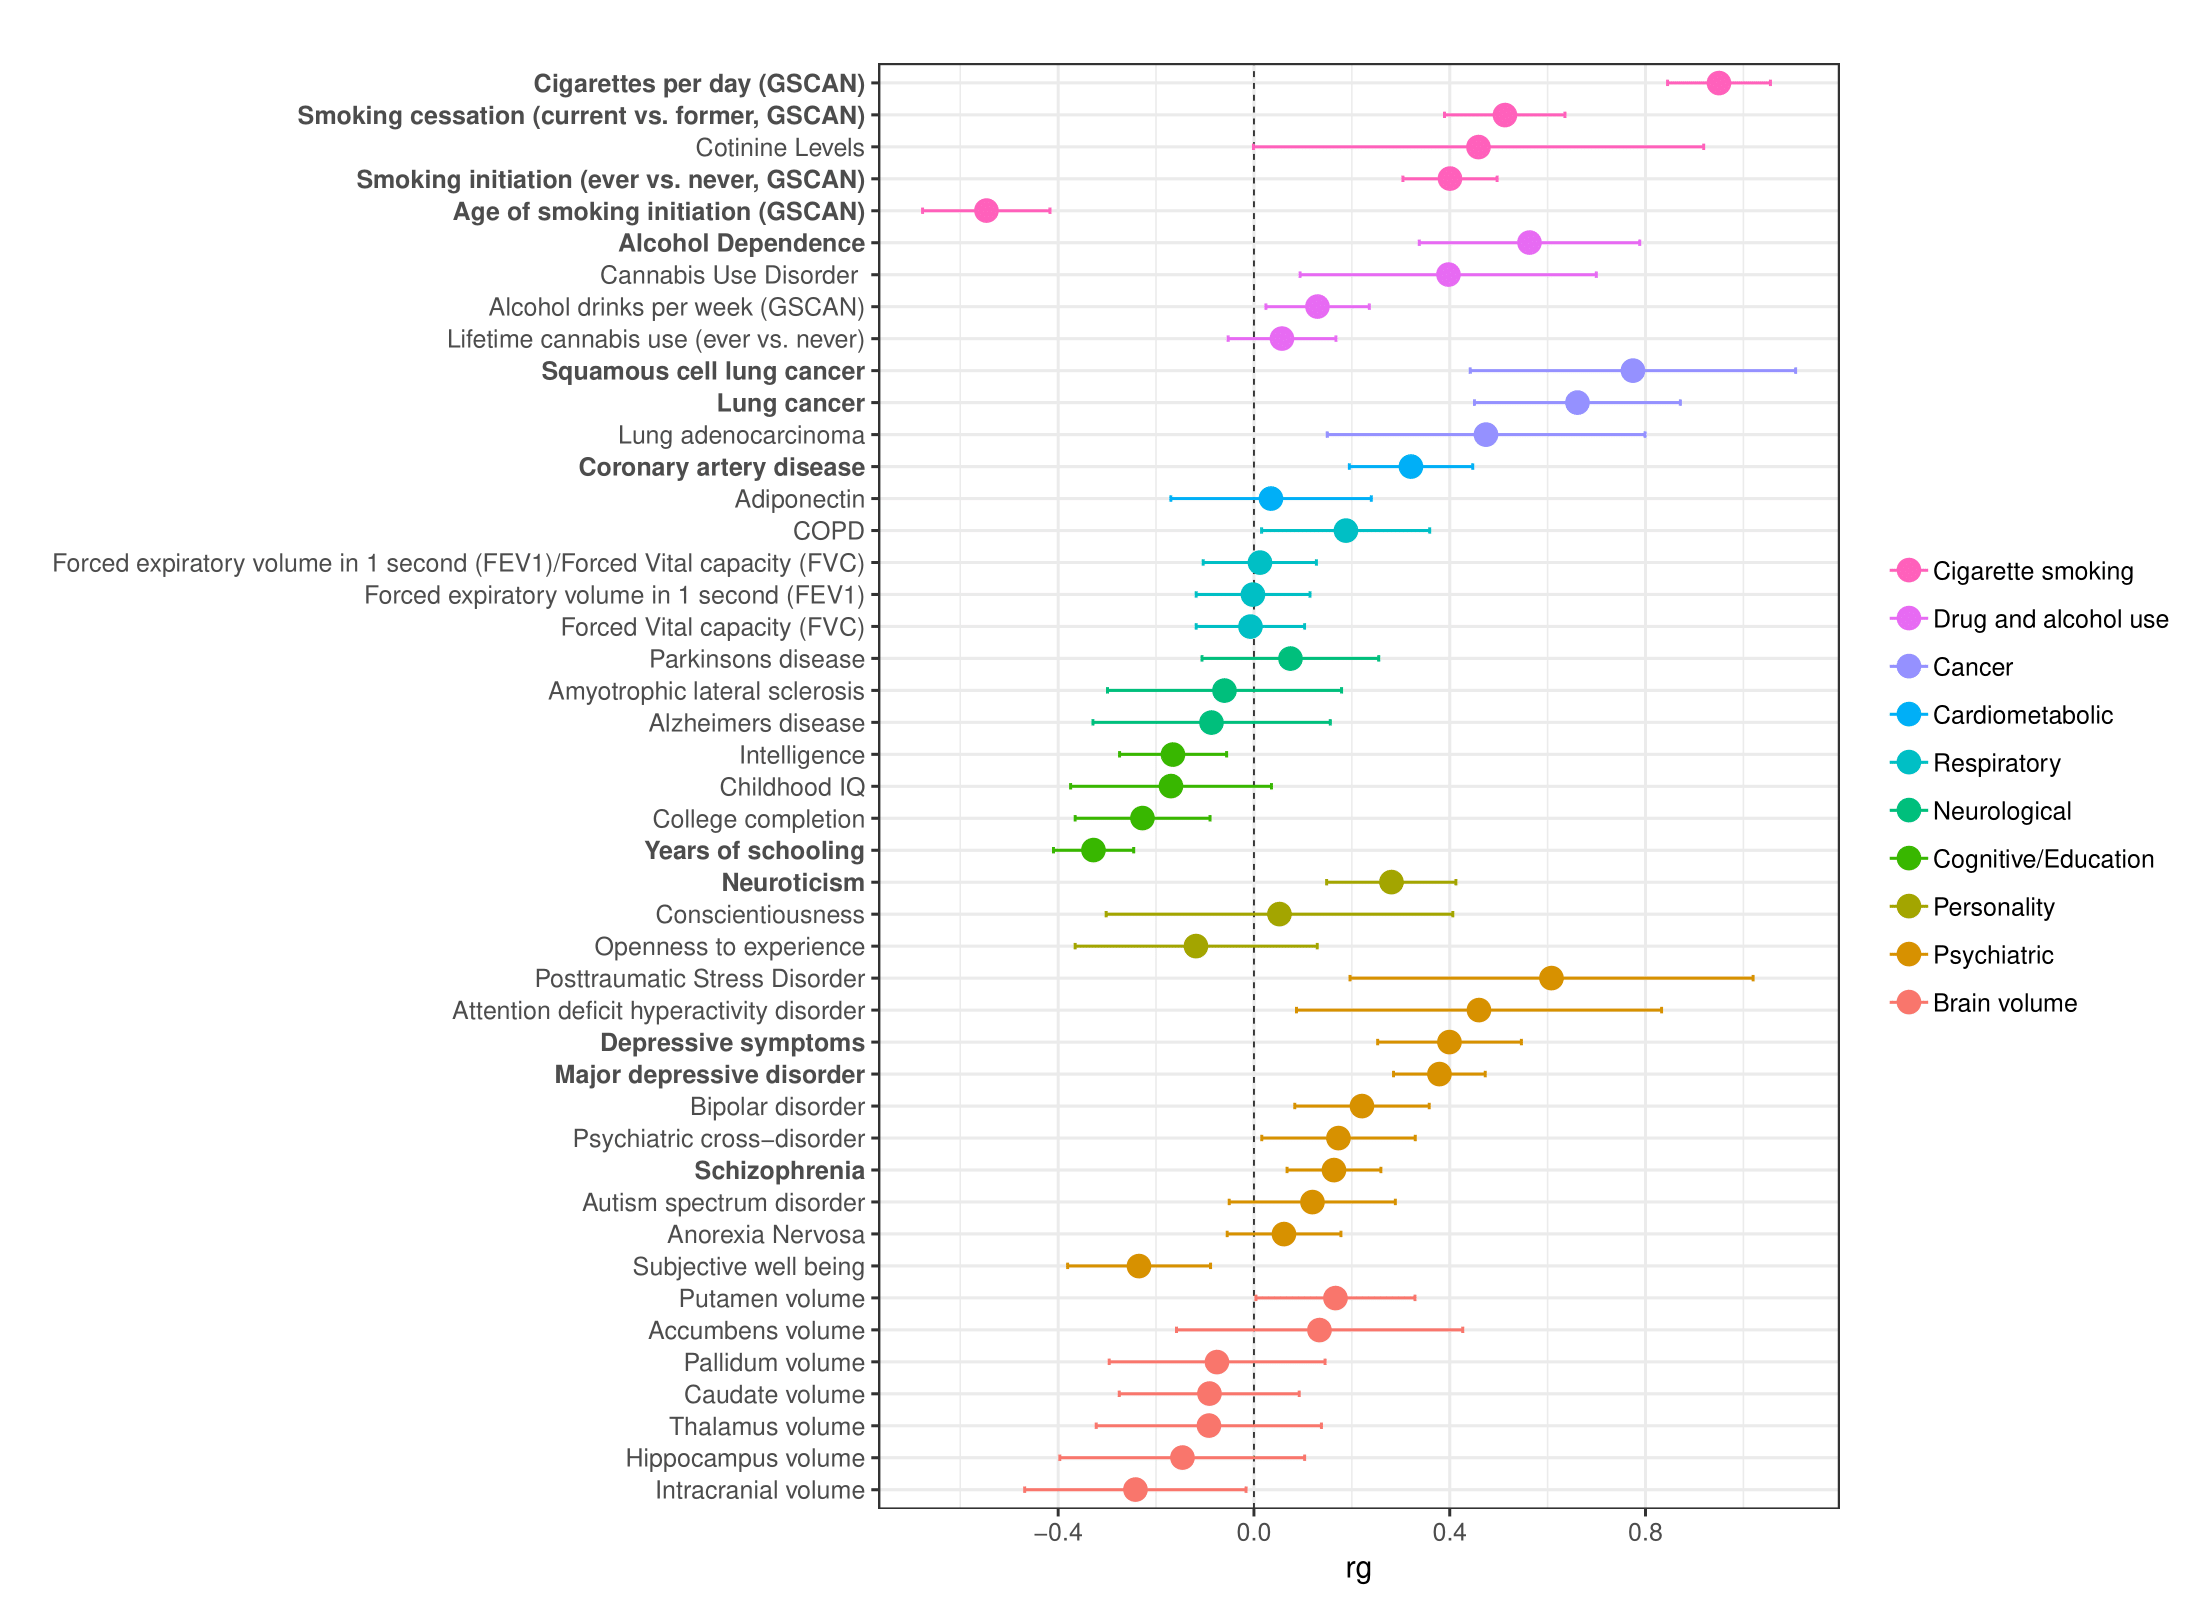

In [1]:

import os
os.chdir("C://Users/jmarks/OneDrive - Research Triangle Institute/Projects/nicotine/ldsc/ftnd_all/002/plot")

## had to first convert the pdf to a png 
from IPython.display import Image
Image("20191023_ftnd_ld_regression_results-1.png")